In [1]:
# import librosa
# import IPython.display
# import matplotlib as mpl
# import matplotlib.font_manager as fm

In [2]:
# data.zip 파일 업로드

In [3]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob
########################################################################


########################################################################
# import additional python-library
########################################################################
import numpy as np
import librosa
import librosa.core
import librosa.display
import librosa.feature
import yaml
import logging
# from import
from tqdm import tqdm
from sklearn import metrics
from keras.models import Model
from keras.layers import Input, Dense
########################################################################

In [4]:
########################################################################
# setup STD I/O
########################################################################
"""
Standard output is logged in "autoencoder.log".
"""
logging.basicConfig(level=logging.DEBUG, filename="autoencoder.log")
logger = logging.getLogger(' ')
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
########################################################################

In [5]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())
# c:\workspace\autoencoder\02_autoencoder

c:\workspace\autoencoder\02_autoencoder


In [6]:
# 스크립트 실행 경로 변경
# c:\workspace\autoencoder\02_autoencoder 으로 변경
os.chdir('c:/workspace/autoencoder/02_autoencoder')

In [7]:
# 현재 스크립트 실행 경로 출력
print(os.getcwd())

c:\workspace\autoencoder\02_autoencoder


In [8]:
# 하위에 dataset 폴더가 존재하지 않으면 생성
os.makedirs('./dataset', exist_ok=True)

In [9]:
# zip file(.wav files) 압축 해제
import zipfile

fantasy_zip = zipfile.ZipFile('./36cc.zip')
fantasy_zip.extractall('./dataset/')
fantasy_zip.close()

In [10]:
fantasy_zip = zipfile.ZipFile('./57cc.zip')
fantasy_zip.extractall('./dataset/')
fantasy_zip.close()

In [11]:
########################################################################

# wav file Input
def file_load(wav_name, mono=False):
    """
    load .wav file.

    wav_name : str
        target .wav file
    sampling_rate : int
        audio file sampling_rate
    mono : boolean
        When load a multi channels file and this param True, the returned data will be merged for mono data

    return : numpy.array( float )
    """
    try:
        return librosa.load(wav_name, sr=None, mono=mono)
    except:
        logger.error("file_broken or not exists!! : {}".format(wav_name))


def demux_wav(wav_name, channel=0):
    """
    demux .wav file.

    wav_name : str
        target .wav file
    channel : int
        target channel number

    return : numpy.array( float )
        demuxed mono data

    Enabled to read multiple sampling rates.

    Enabled even one channel.
    """
    try:
        multi_channel_data, sr = file_load(wav_name)
        if multi_channel_data.ndim <= 1:
            return sr, multi_channel_data

        return sr, np.array(multi_channel_data)[channel, :]

    except ValueError as msg:
        logger.warning(f'{msg}')


########################################################################

In [12]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    # sr, y = demux_wav(SOURCE)
    y, sr = librosa.load(SOURCE, sr=None, mono=False)

    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  

In [13]:
import wfdb

In [14]:
rd_record = wfdb.rdrecord('pure_0.wav')

Reading Mono formatted .wav file...
Sample rate: 44100
Byte rate: 88200
Block align: 2
Bits per sample: 16


In [15]:
rd_record = wfdb.rdrecord('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav')

Reading Mono formatted .wav file...
Sample rate: 51200
Byte rate: 102400
Block align: 2
Bits per sample: 16


Exception: Format chunk missing or corrupt

In [16]:
# https://ahnjg.tistory.com/84
# librosa.load와 scipy.io.wavfile.read의 차이점

In [17]:
import scipy.io.wavfile
scipy_sr, scipy_y = scipy.io.wavfile.read('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav')

In [18]:
print(f"scipy_sr = {scipy_sr}")

scipy_sr = 51200


In [19]:
print(f"scipy_y.shape = {scipy_y.shape}")
# print(f"number of channels = {scipy_y.shape[1]}")

scipy_y.shape = (1369362,)


In [20]:
wavelength = scipy_y.shape[0] / scipy_sr
print(f"length = {wavelength}s")

length = 26.7453515625s


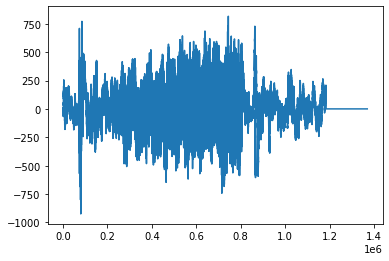

In [21]:
plt.plot(scipy_y)

In [22]:
librosa_y, librosa_sr = librosa.load('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav')

In [23]:
print('scipy_y.shape:', scipy_y.shape)
print('type(scipy_y[0]):', type(scipy_y[0]))
print('scipy_sr:', scipy_sr)
print('--------------------------------------')
print('librosa_y.shape:', librosa_y.shape)
print('type(librosa_y[0]):', type(librosa_y[0]))
print('librosa_sr:', librosa_sr)


scipy_y.shape: (1369362,)
type(scipy_y[0]): <class 'numpy.int16'>
scipy_sr: 51200
--------------------------------------
librosa_y.shape: (589736,)
type(librosa_y[0]): <class 'numpy.float32'>
librosa_sr: 22050


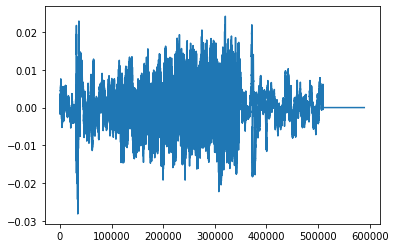

In [24]:
plt.plot(librosa_y)

C:\Users\astro\AppData\Local\Temp\ipykernel_17308\3542624437.py:6: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(librosa_y, librosa_sr)#, alpha=0.5)


Text(0.5, 1.0, 'librosa.display.waveshow(y=audio time series, sr=sampling rate')

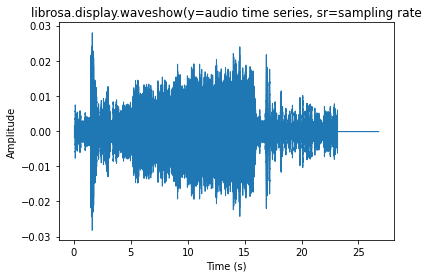

In [25]:
# https://www.dacon.io/competitions/official/235616/codeshare/1277
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
# Visualize a waveform in the time domain
# y축은 진폭, x축은 시간을 나타낸다.
plt.figure()
librosa.display.waveshow(librosa_y, librosa_sr)#, alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("librosa.display.waveshow(y=audio time series, sr=sampling rate")

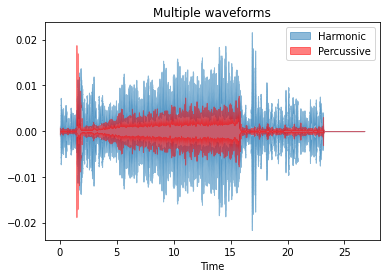

In [26]:
fig, ax = plt.subplots(nrows=1, sharex=True)
y_harm, y_perc = librosa.effects.hpss(librosa_y)
librosa.display.waveshow(y_harm, sr=librosa_sr, alpha=0.5, ax=ax, label='Harmonic')
librosa.display.waveshow(y_perc, sr=librosa_sr, color='r', alpha=0.5, ax=ax, label='Percussive')
ax.set(title='Multiple waveforms')
ax.legend()

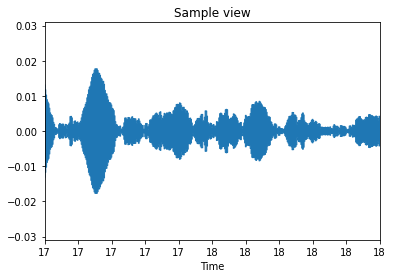

In [27]:
# https://www.dacon.io/competitions/official/235616/codeshare/1277
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
fig, ax = plt.subplots(nrows=1, sharex=True)
ax.set(xlim=[17.00, 18.00], title='Sample view')#, ylim=[-0.2, 0.2])
librosa.display.waveshow(librosa_y, sr=librosa_sr, ax=ax, marker='.', label='Full signal')
ax.label_outer()
#Rax.legend()

In [28]:
import seaborn as sns

C:\Users\astro\anaconda3\envs\ae2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

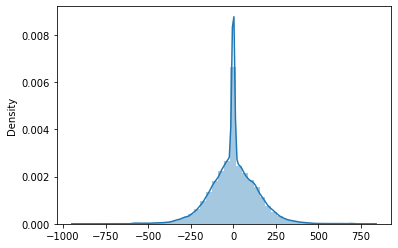

In [29]:
sns.distplot(scipy_y)

C:\Users\astro\anaconda3\envs\ae2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

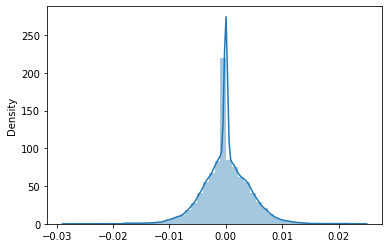

In [30]:
sns.distplot(librosa_y)

In [31]:
# librosa로 가져온 데이터는 -1 ~ 1 의 범위로 정규화 되어있다.
# liborsa 입력에서 sr=None 로 지정하지 않고 임의의 sample_rate를 설정하면 load할 때 resampling을 수행한다.

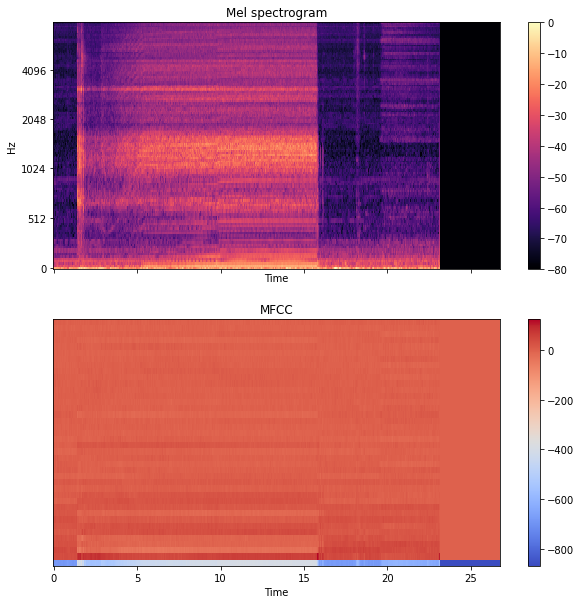

In [32]:
# https://librosa.org/doc/0.9.1/generated/librosa.feature.mfcc.html
# librosa.feature.mfcc
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=librosa_y, sr=librosa_sr, n_mels=128,
                                   fmax=8000)

# Generate mfccs from a time series
mfccs = librosa.feature.mfcc(y=librosa_y, sr=librosa_sr, n_mfcc=40)

# Visualize the MFCC series
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,10))

# ax[0]
img = librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=8000,
                               ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='Mel spectrogram')
# ax[0].label_outer()

# ax[1]
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')
ax[1].label_outer()

In [33]:
# https://librosa.org/doc/0.9.1/generated/librosa.display.specshow.html
# librosa.display.specshow
# Display a spectrogram/chromagram/cqt/etc.

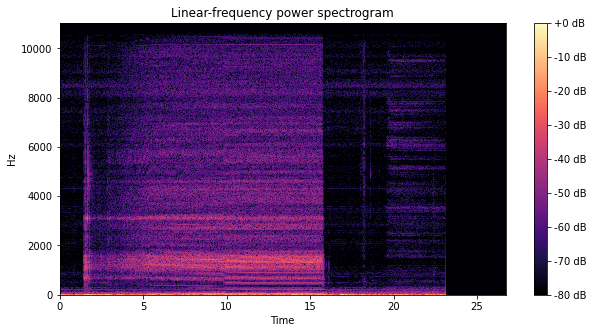

In [34]:
# https://librosa.org/doc/0.9.1/generated/librosa.display.specshow.html
#Visualize an STFT power spectrum using default parameters
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(10,5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(librosa_y)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=librosa_sr, ax=ax)
ax.set(title='Linear-frequency power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")                            

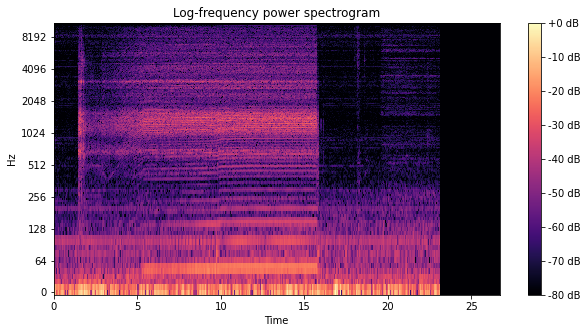

In [35]:
# https://librosa.org/doc/0.9.1/generated/librosa.display.specshow.html
# logarithmic scale, and using a larger hop
fig, ax = plt.subplots(figsize=(10,5))
hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(librosa_y, hop_length=hop_length)),
                            ref=np.max)
img = librosa.display.specshow(D, y_axis='log', sr=librosa_sr, hop_length=hop_length,
                         x_axis='time', ax=ax)
ax.set(title='Log-frequency power spectrogram')
ax.label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB") 

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

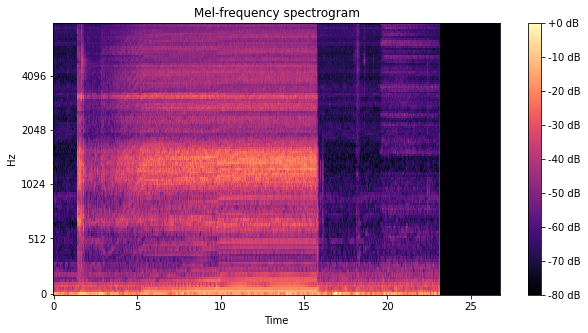

In [36]:
# https://librosa.org/doc/0.9.1/generated/librosa.feature.melspectrogram.html
# librosa.feature.melspectrogram
S = librosa.feature.melspectrogram(y=librosa_y, sr=librosa_sr, n_mels=128,
                                    fmax=8000)
fig, ax = plt.subplots(figsize=(10,5))
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=librosa_sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

C:\Users\astro\AppData\Local\Temp\ipykernel_17308\1222045341.py:6: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(y, sr, ax=ax)


[Text(0.5, 1.0, 'Waveshow')]

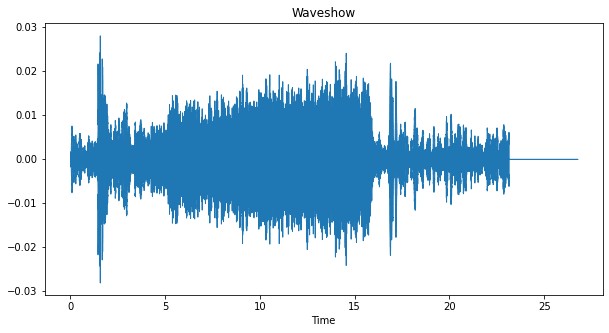

In [59]:
y, sr = librosa.load('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav')

# waveshow
# https://librosa.org/doc/0.9.1/generated/librosa.display.waveshow.html#librosa.display.waveshow
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(10,5))
librosa.display.waveshow(y, sr, ax=ax)
ax.set(title='Waveshow')

In [112]:
stft = librosa.stft(y)
print(np.min(stft))
print(np.max(stft))

absstft = np.abs(stft)
print(np.min(absstft))
print(np.max(absstft))

amp_to_db = librosa.amplitude_to_db(absstft)
print(np.min(amp_to_db))
print(np.max(amp_to_db))


(-14.481238+0j)
(17.581663+0j)
0.0
17.581663
-55.0988
24.9012


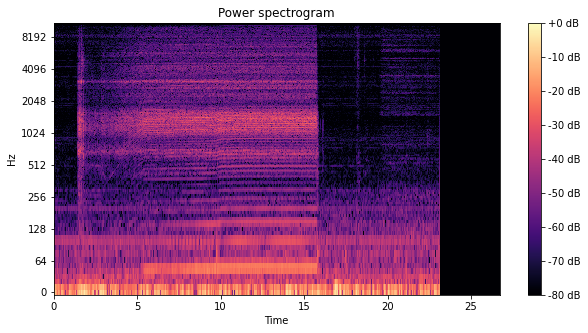

In [106]:
y, sr = librosa.load('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav')
S = np.abs(librosa.stft(y))
# Power spectrogram
# https://librosa.org/doc/0.9.1/generated/librosa.power_to_db.html
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

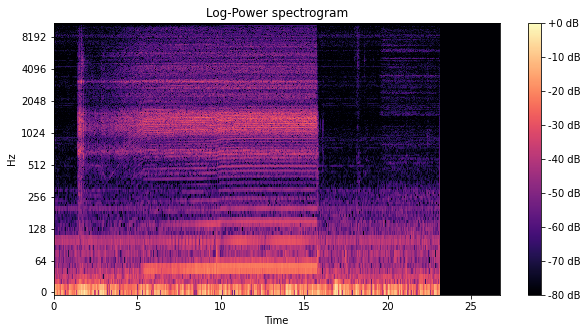

In [76]:
y, sr = librosa.load('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav')

# Log-Power spectrogram
# https://librosa.org/doc/0.9.1/generated/librosa.power_to_db.html
# librosa.power_to_db
# Convert a power spectrogram (amplitude squared) to decibel (dB) units
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(10,5))
S = np.abs(librosa.stft(y))
imgdb = librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max),
                                 sr=sr, y_axis='log', x_axis='time', ax=ax)
ax.set(title='Log-Power spectrogram')
fig.colorbar(imgdb, ax=ax, format="%+2.0f dB")

36cc-normal


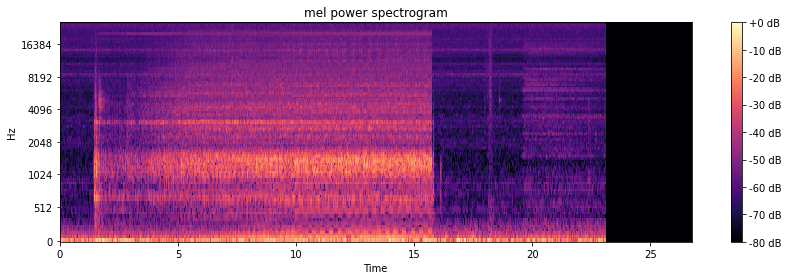

36cc-abnormal


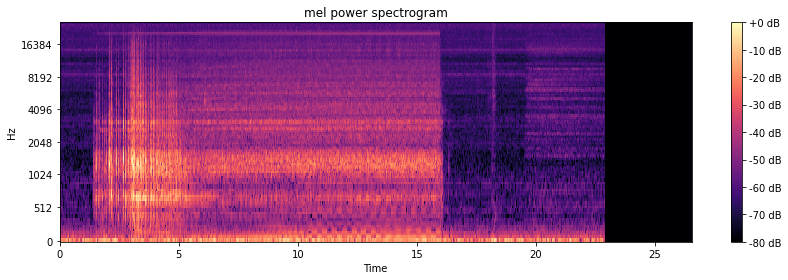

In [72]:
# 원본 36cc-normal 소리와 원본 36cc-abnormal 소리를 1개씩 spectrogra으로 변환하여 비교
print("36cc-normal")
make_iamge('./dataset/36cc/normal/2208211119H0010019498_TDM_2022-03-30_15-23-56__Microphone.wav', '')
print("36cc-abnormal")
make_iamge('./dataset/36cc/abnormal/2208211119H0010019698_TDM_2022-03-30_16-22-03__Microphone.wav', '')

57cc-normal


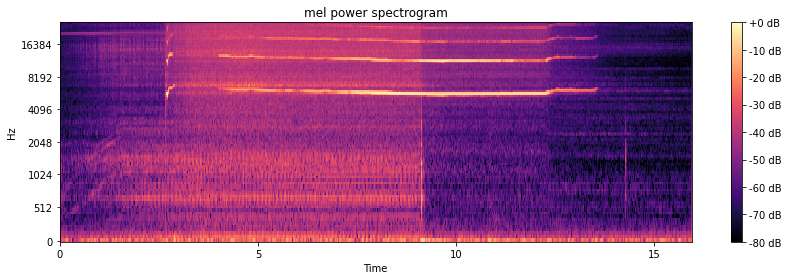

57cc-abnormal


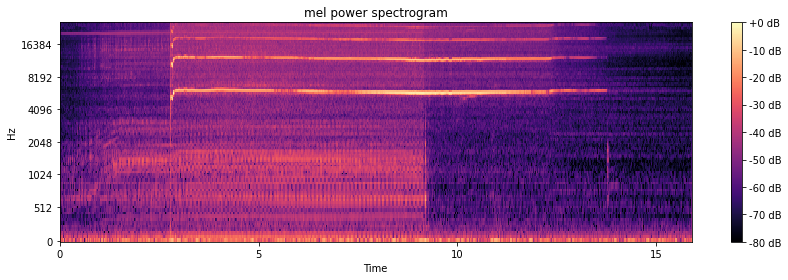

In [40]:
# 원본 57cc-normal 소리와 원본 57cc-abnormal 소리를 1개씩 spectrogra으로 변환하여 비교
print("57cc-normal")
make_iamge('./dataset/57cc/normal\OK_121281111NB982000265218.wav', '')
print("57cc-abnormal")
make_iamge('./dataset/57cc/abnormal/NOK_121284111NB982000312818.wav', '')

In [41]:
import matplotlib.pyplot as plt

# spectrograms 변환 함수 만들기
# 참고: https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html
def make_iamge(SOURCE,
               TARGET,
               n_mels=128,
               frames=5,
               n_fft=1024,
               hop_length=512,
               power=2.0):

    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 generate melspectrogram using librosa (**kwargs == param["librosa"])
    sr, y = demux_wav(SOURCE)

    # file = SOURCE
    # y, sr = librosa.load(file) # (default  sr=22050)
    # Return
      # y: np.ndarray [shape=(n,) or (…, n)] / audio time series. Multi-channel is supported.
      # sr: number > 0 [scalar / sampling rate of
    # S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                     sr=sr,
                                                     n_fft=n_fft,
                                                     hop_length=hop_length,
                                                     n_mels=n_mels,
                                                     power=power)

    # Returns
      # S: np.ndarray [shape=(…, n_mels, t)] / Mel spectrogram
    S_dB = librosa.power_to_db(mel_spectrogram, ref=np.max)
    if TARGET == '':
      plt.figure(figsize=(12, 4))
      librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
      plt.title('mel power spectrogram')
      plt.colorbar(format='%+02.0f dB')
      plt.tight_layout()
      plt.show()
    else:
      fig = plt.figure(figsize=(15, 15))
      plt.axis('off')
      librosa.display.specshow(S_dB, sr=sr)
      plt.savefig(TARGET, bbox_inches='tight', pad_inches=0)
      plt.close(fig)  